# Regression Model Challenge
- In this challenge we take the housing dataset and compare and contrast four different types of regression and their predicitive capabilities based on a housing sales price target variable.

In [172]:
import numpy as np #import necessary packages, modules
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import math
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student' #connect to student database
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [173]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

## Data Exploration and Cleaning 

In [4]:
housing_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


- Looking through the column data, we see multiple types of data entries and parameters

In [5]:
housing_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


- We look for any values that seem unexpected, any max or minimum entries that seem incorrect

In [6]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

- Some columns that are numerical and some are non-numerical. It is an important difference, if we would like to use categorical data in the regression model, the categorical data will first have to be converted to numerical values.

In [7]:
non_numeric_columns = housing_df.select_dtypes(['object']).columns #select non-numeric columns for review
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [8]:
numeric_columns = housing_df.select_dtypes(['int64', 'float64']).columns #select numeric columns for review
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


In [9]:
total_missing = housing_df.isnull().sum().sort_values(ascending=False) 
                    #find the total null data values in each column based on percentage of data points in each column 

percent_missing = (housing_df.isnull().sum()/housing_df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])

missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


- 19 of the features have missing values. The missing data of type int or float can be handled by interpolation.

In [11]:
fill_list = ['lotfrontage','garageyrblt','masvnrarea'] 
                                    #use the interpolation method to fill the missing data in the numeric data columns

for col in housing_df:
    housing_df.loc[:, col].interpolate(inplace=True) 

- converting the missing values in the columns of type float 

- continuing with column data analysis, we look at what outliers may be present in the data.

<Figure size 432x288 with 0 Axes>

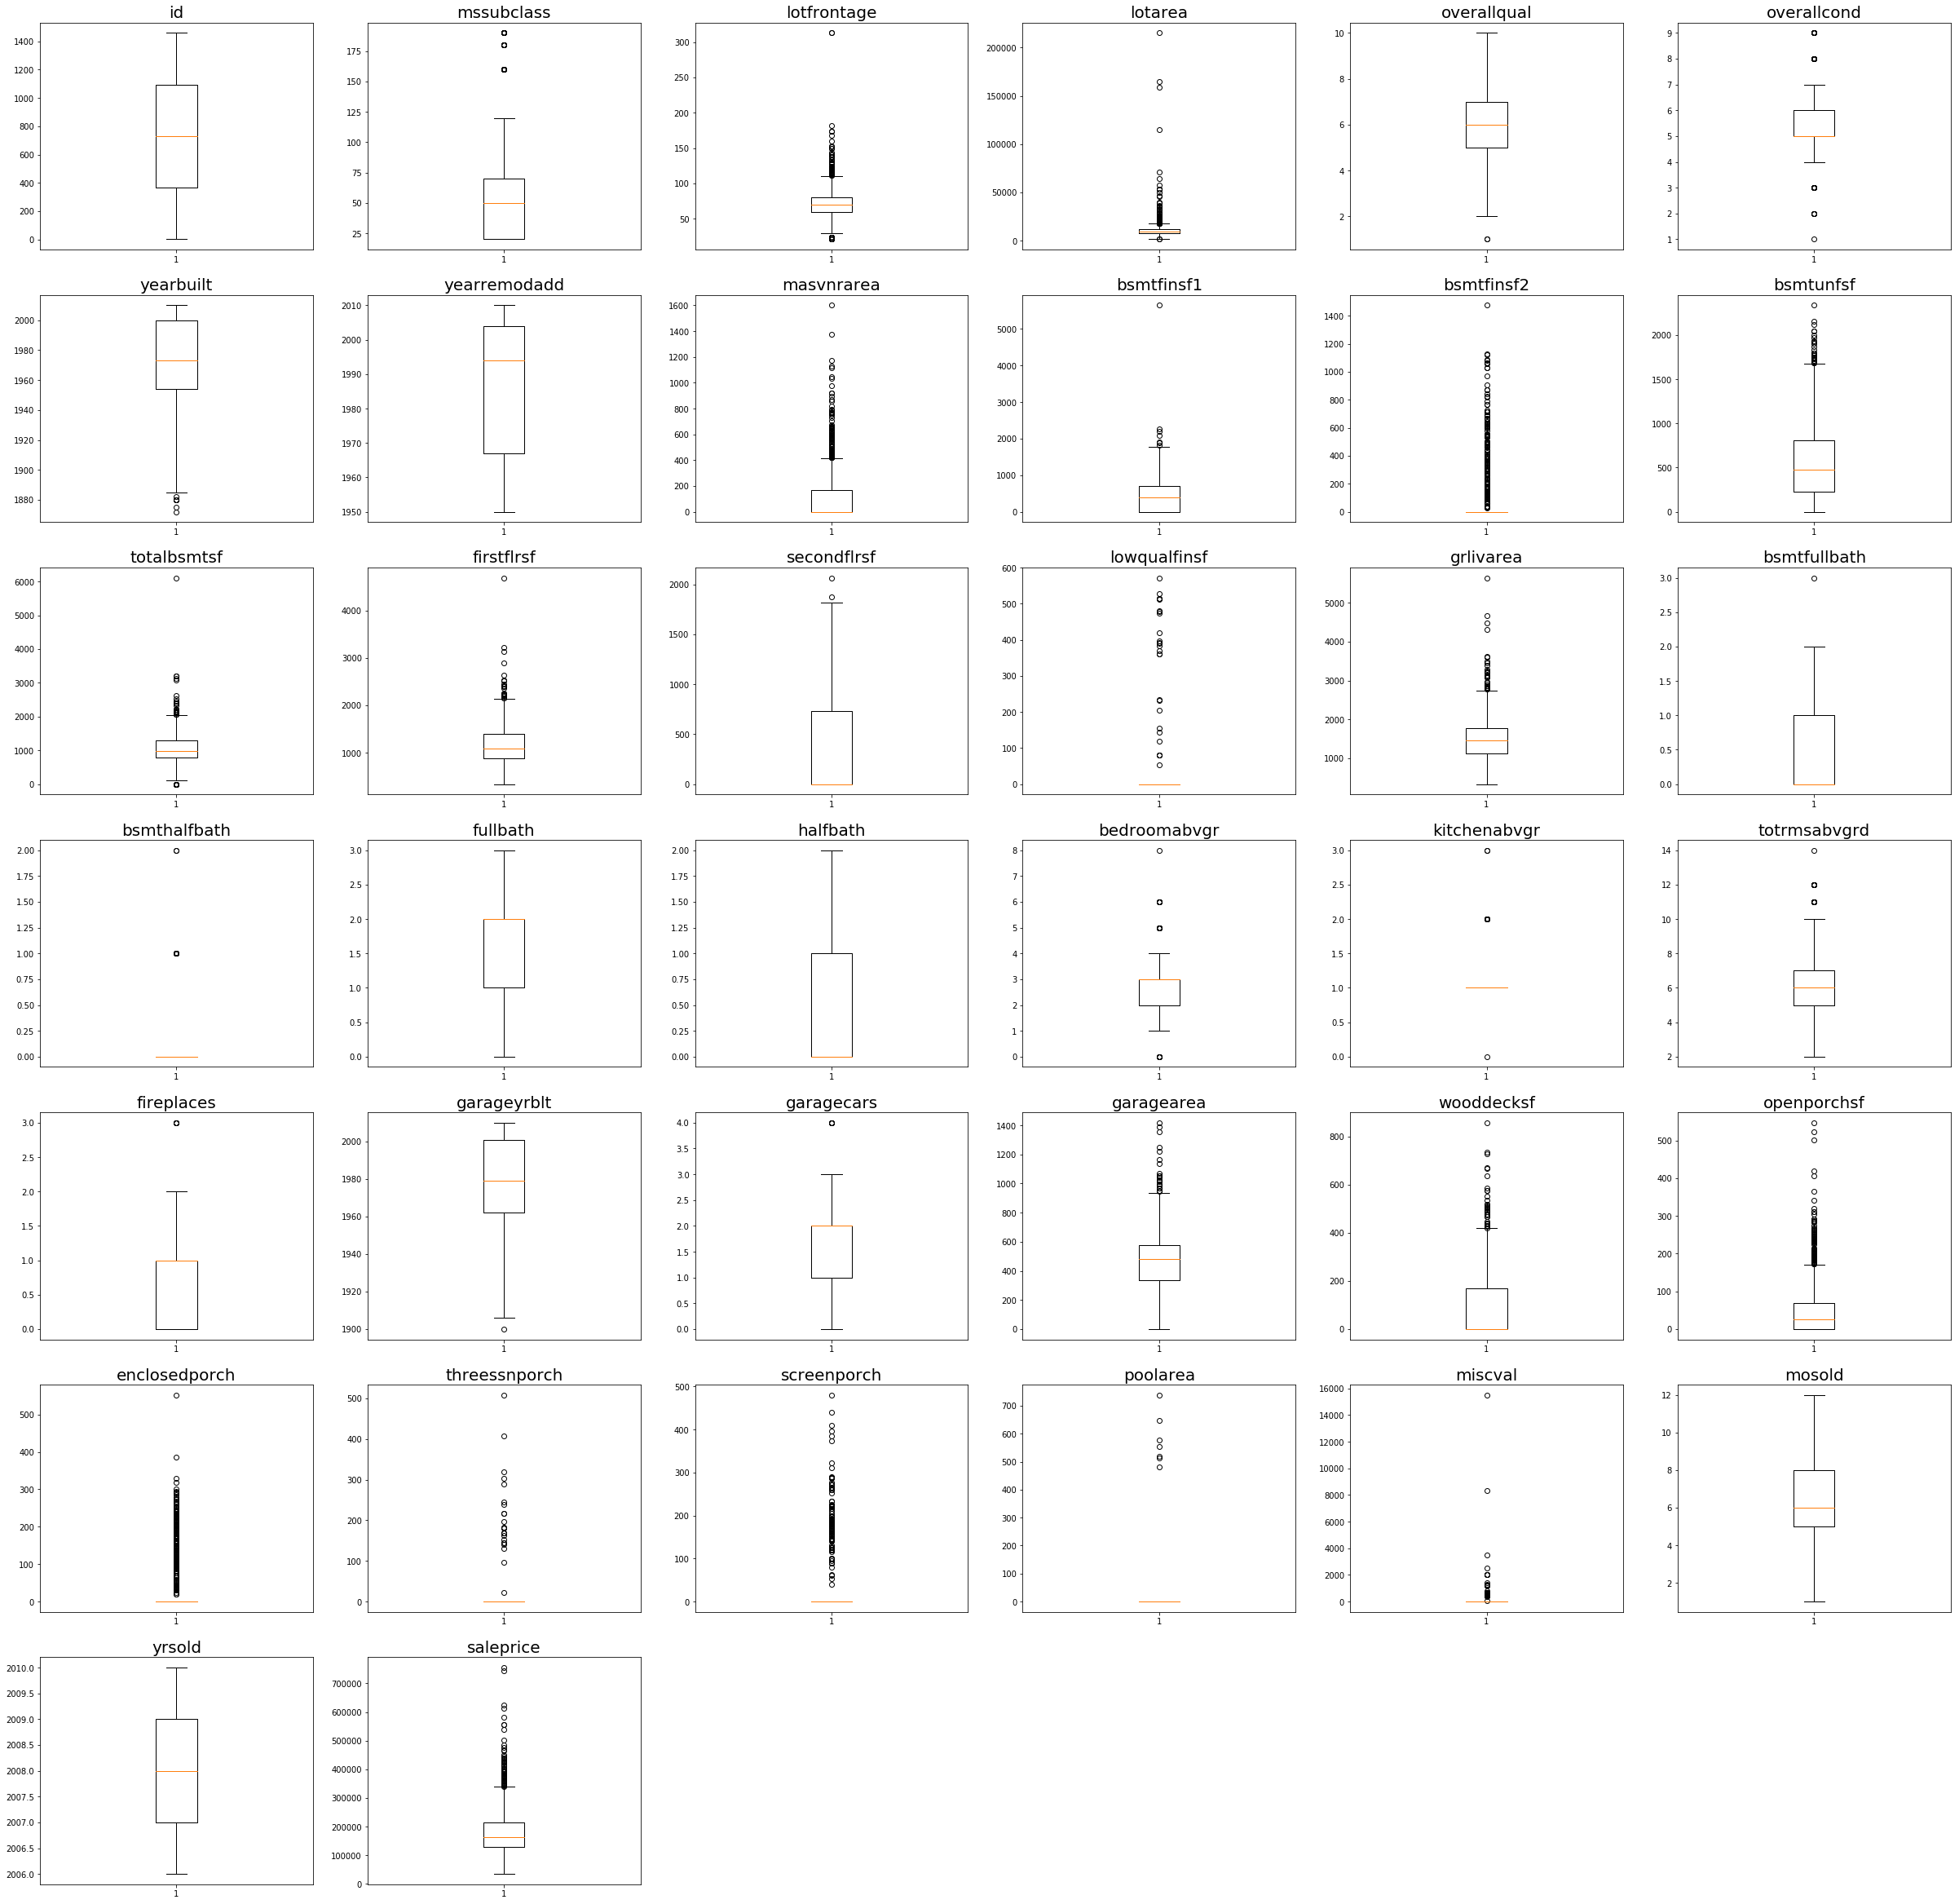

In [12]:
housing_int_df = housing_df.select_dtypes(include=['float64','int']) 
                                                            #create boxplot analysis to assess presence of outliers 

def get_boxplot(df):
    ceil = math.ceil(math.sqrt(len(df.columns)))
    flr = math.floor(math.sqrt(len(df.columns)))
    plt.figure(figsize=(ceil*flr,ceil*flr))
    i = 1
    #print(df.columns)
    for column in df.columns: 
        plt.subplot(ceil,flr,i)
        plt.boxplot(df[column])
        plt.title(df[column].name,fontsize=20)
        i+=1
plt.tight_layout()
plt.show() 

get_boxplot(housing_int_df)

- We see the presence of many outliers in the numerical data, a quick function deletes all data point further than 3 standard deviations away from the respective mean.

In [159]:
for col in housing_int_df: #take only values within plus of minus 3 st of the respective column data mean 
    housing_df = housing_df[((housing_df[col] - housing_df[col].mean()) / housing_df[col].std()).abs() < 3] 

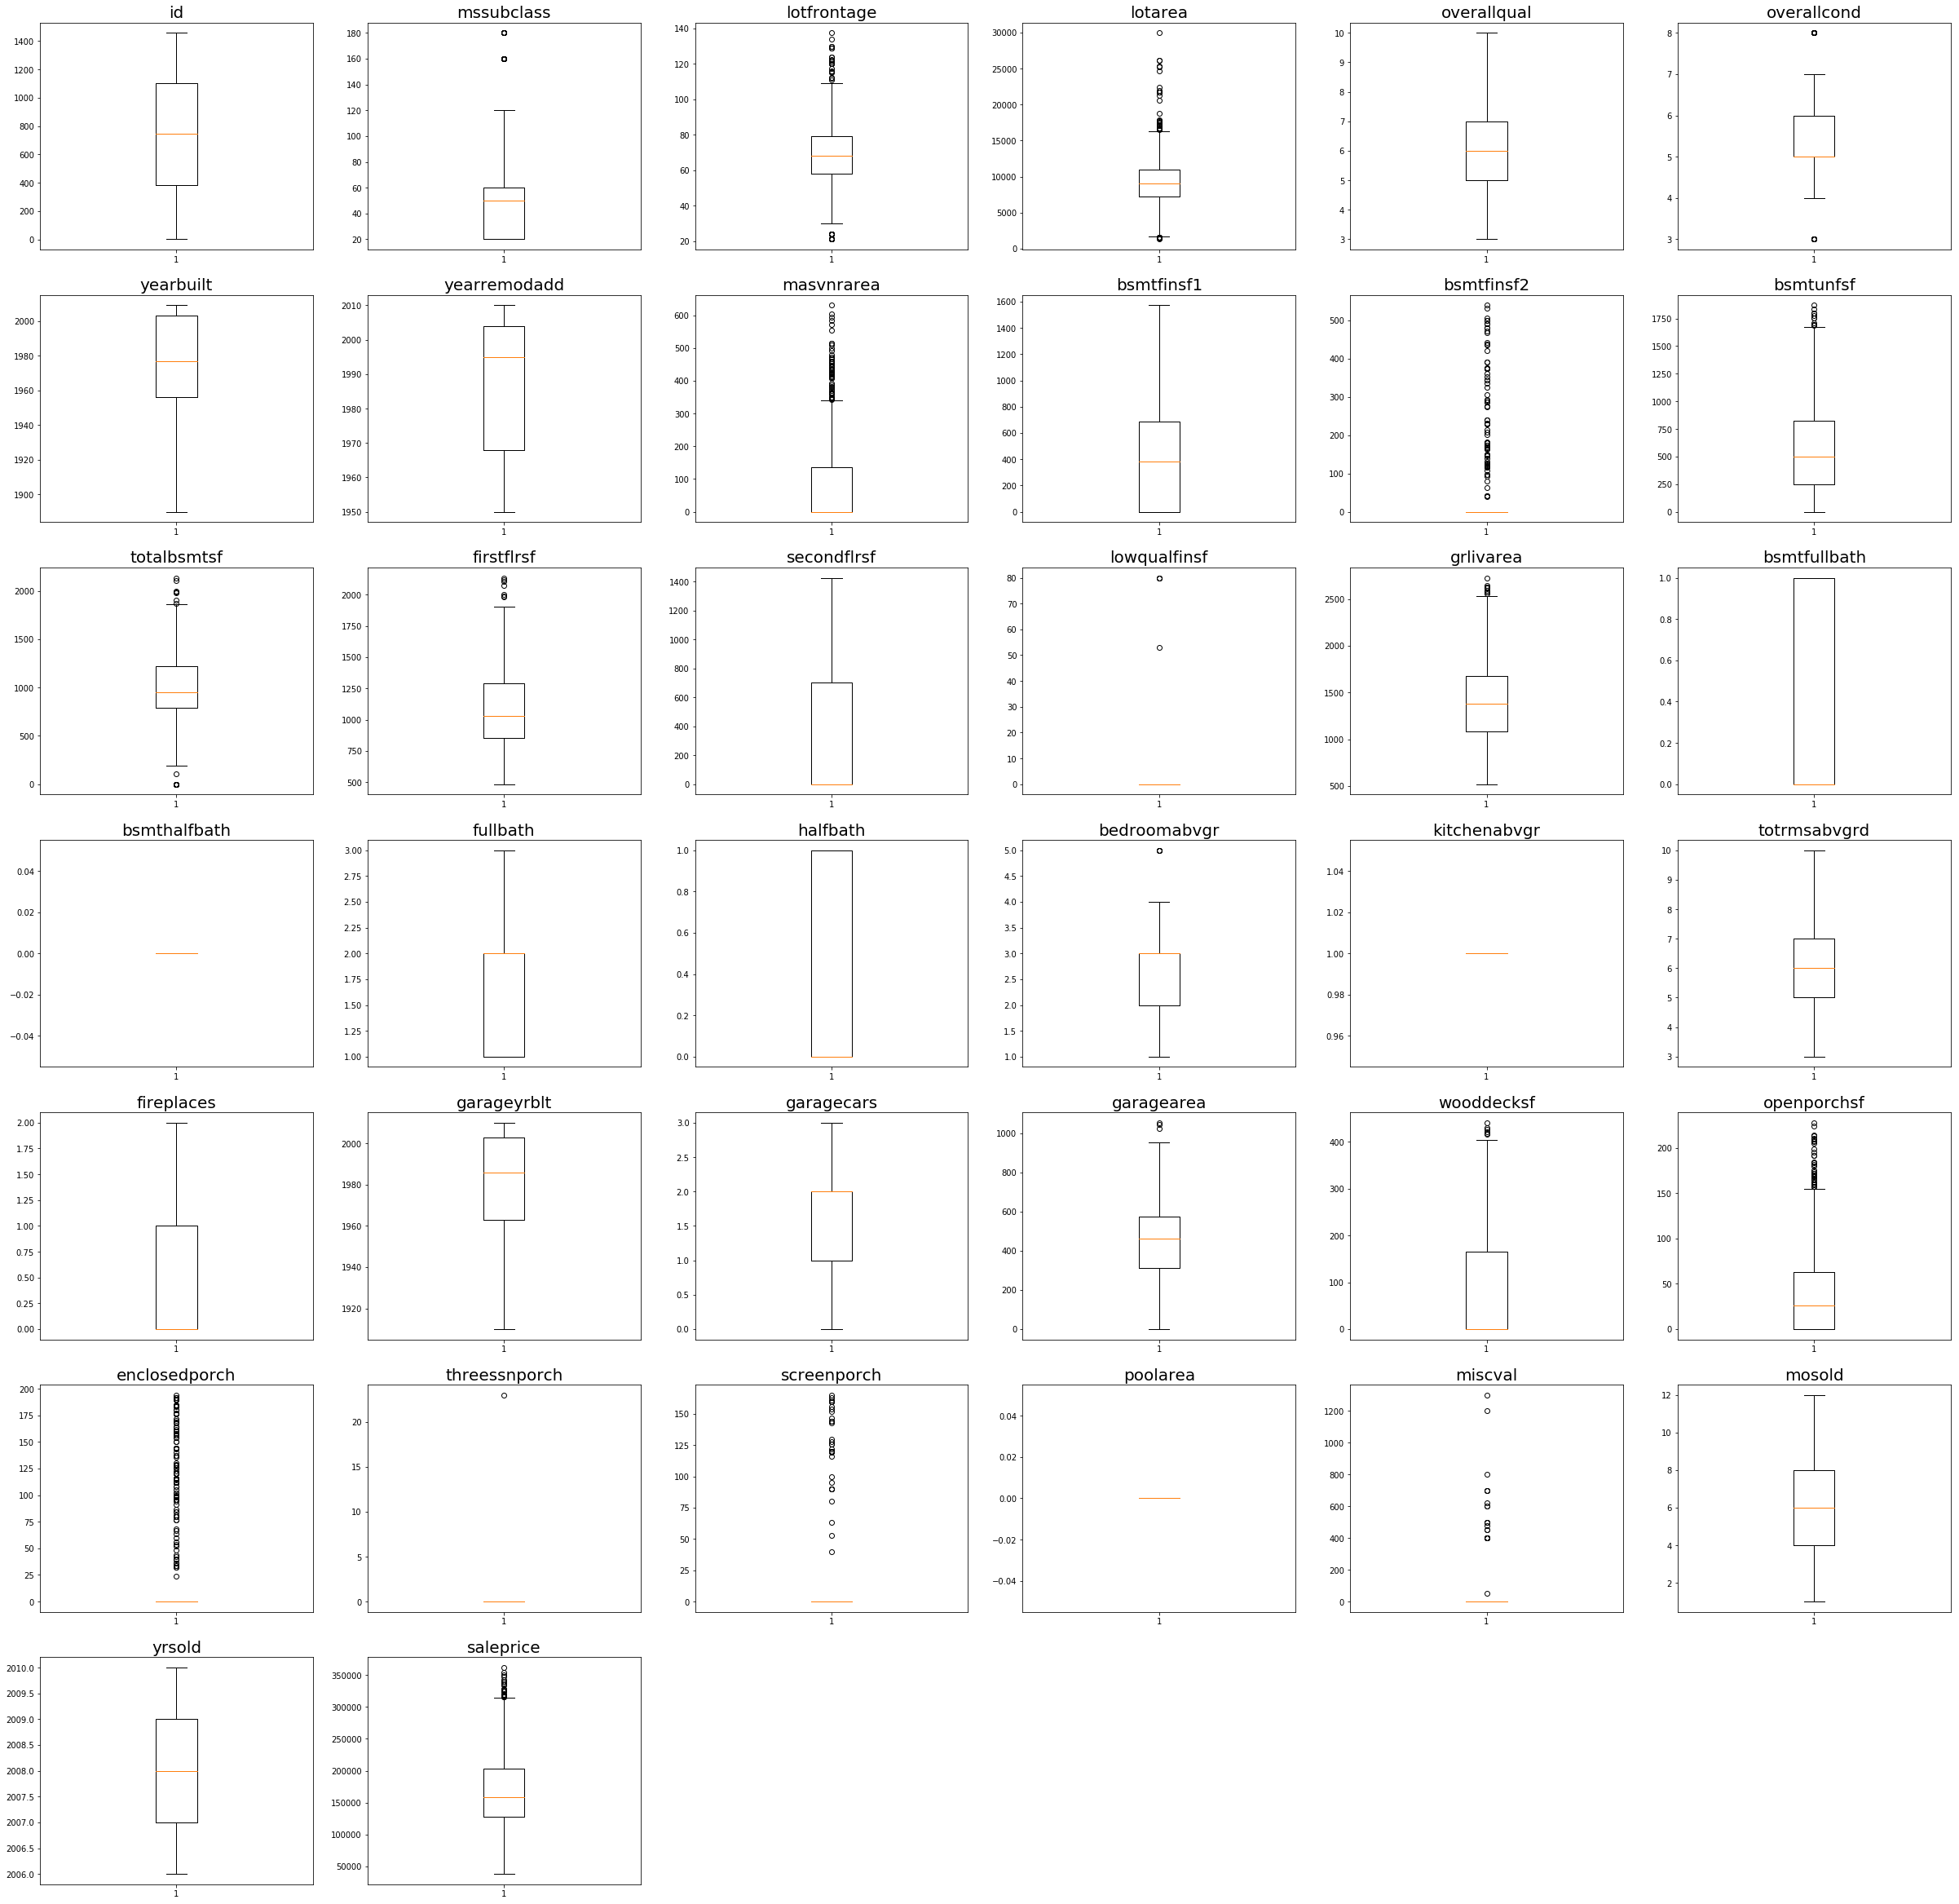

In [14]:
get_boxplot(housing_df.select_dtypes(include=['float64','int'])) #create box plot analysis to assess outliers

## Analysis and Feature Selection

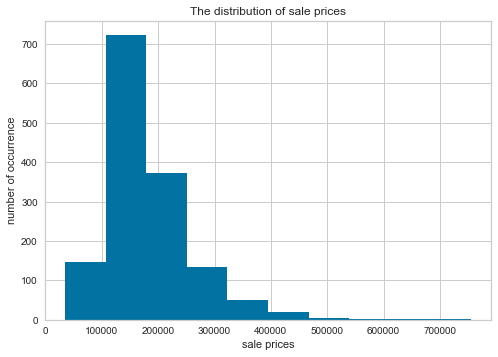

In [174]:
plt.hist(housing_df.saleprice) #create plot to visualize the distribution of target data
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

-  Our target variable saleprice seems to be distributed non-normally.

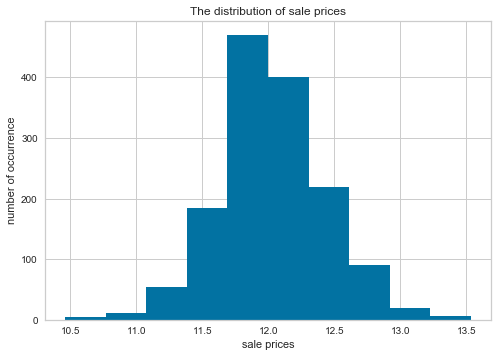

In [175]:
plt.hist(np.log1p(housing_df['saleprice'])) #create plot to visualize log transform of target data
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

- transforming the target variable 'sale price' with a logarithmic transformation, 

- Then we create a couple of QQplots to compare the shape of the original vs transformed data.

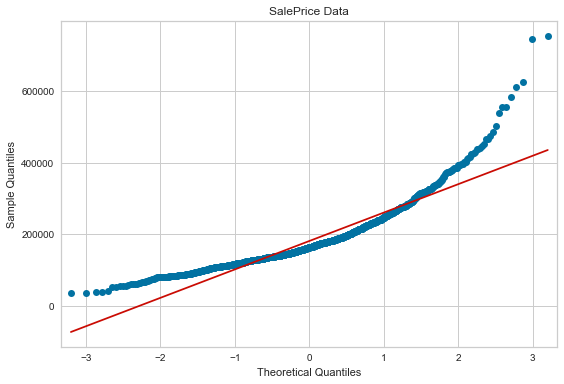

In [197]:
from statsmodels.graphics.gofplots import qqplot

qqplot(housing_df['saleprice'], line='s') #Create QQplot to investigate the normality of age data
plt.title('SalePrice Data')           

plt.tight_layout()
plt.show()

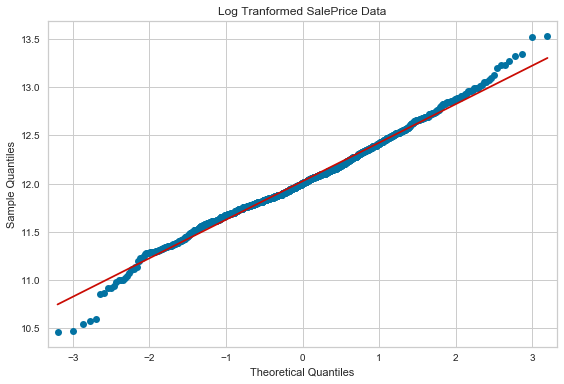

In [200]:
qqplot(np.log1p(housing_df['saleprice']), line='s') #Create QQplot to investigate the normality of age data
plt.title('Log Tranformed SalePrice Data')           

plt.tight_layout()
plt.show()

-  We can see the transformed sael price data is much more normal in distribution.

In [18]:
np.abs(housing_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.809931
grlivarea        0.766846
garagecars       0.693455
fullbath         0.674854
garagearea       0.667357
yearbuilt        0.636706
totalbsmtsf      0.602579
totrmsabvgrd     0.592997
firstflrsf       0.566466
yearremodadd     0.560674
garageyrblt      0.552038
fireplaces       0.417418
openporchsf      0.414354
masvnrarea       0.391524
lotarea          0.364041
secondflrsf      0.351586
lotfrontage      0.348752
wooddecksf       0.336825
bsmtfinsf1       0.304781
halfbath         0.284241
bedroomabvgr     0.278110
bsmtunfsf        0.234547
bsmtfullbath     0.213220
enclosedporch    0.204289
overallcond      0.172380
bsmtfinsf2       0.098095
mosold           0.090788
miscval          0.063823
yrsold           0.028818
lowqualfinsf     0.019786
mssubclass       0.014725
screenporch      0.008597
threessnporch    0.000007
bsmthalfbath          NaN
kitchenabvgr          NaN
poolarea              NaN
Name: saleprice, dtype: float64

- Taking the correlations of the features with our target variable irrespective of their signs by taking absolute values.

- To understand the relationships between our target variable and features, plot each feature against the target variable. 
- In the charts below, we show the average sale prices with respect to the each categories of a feature.

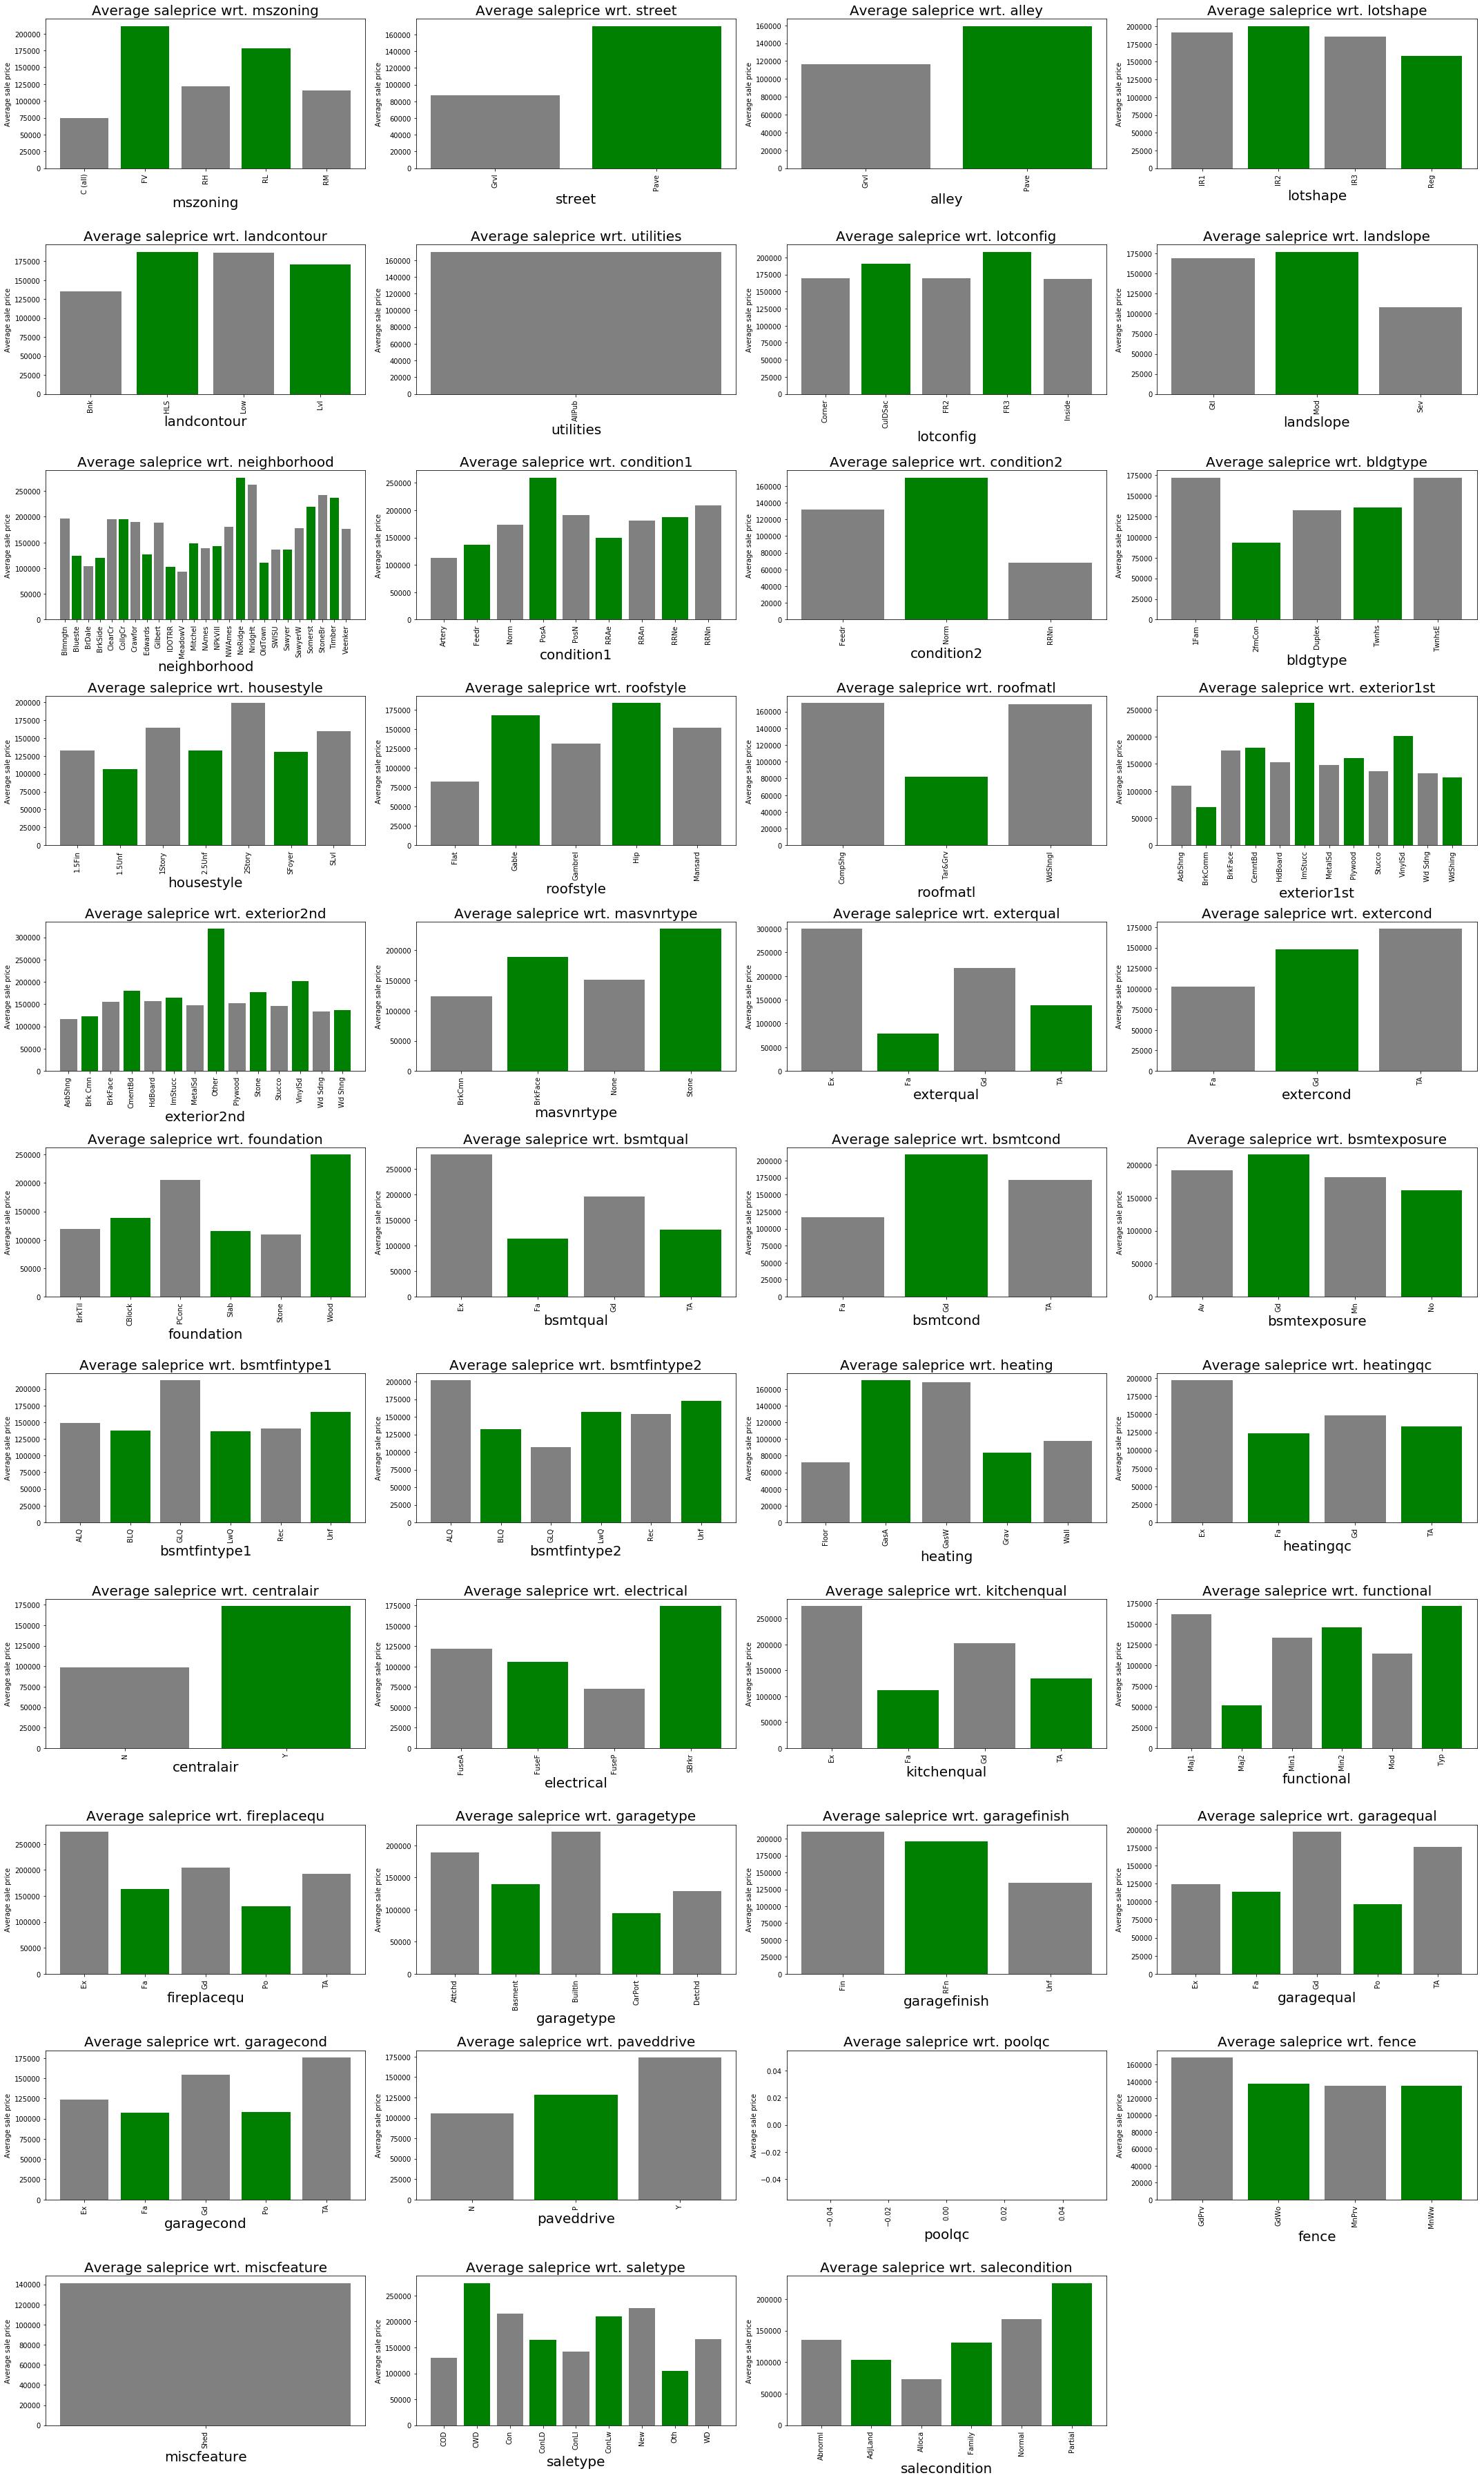

In [19]:
plt.figure(figsize=(30,50))
#Create bar chart analysis to assess the variance with respect to class data within each non-numerical predictor
for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(housing_df.groupby(column)["saleprice"].mean().index, housing_df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column),fontsize=20)
    plt.ylabel("Average sale price")
    plt.xlabel(column,fontsize=20)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [20]:
housing_reg_df =  housing_df.copy() #Create dumy variables for OLS model from selected categorical data
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.centralair, 
                                                            prefix="centralair", drop_first=True)], axis=1)
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.mszoning, 
                                                            prefix="mszoning", drop_first=True)], axis=1)
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.bldgtype, 
                                                            prefix="bldgtype", drop_first=True)], axis=1)
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.exterqual, 
                                                            prefix="exterqual", drop_first=True)], axis=1)
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.bsmtqual, 
                                                            prefix="bsmtqual", drop_first=True)], axis=1)
housing_reg_df = pd.concat([housing_reg_df,pd.get_dummies(housing_reg_df.salecondition, 
                                                            prefix="salecondition", drop_first=True)], axis=1)

In [21]:
dummy_column_names = list(pd.get_dummies(housing_reg_df.centralair, prefix="centralair", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(housing_reg_df.mszoning, prefix="mszoning", 
                drop_first=True).columns)+ list(pd.get_dummies(housing_reg_df.bldgtype, prefix="bldgtype", 
                drop_first=True).columns)+ list(pd.get_dummies(housing_reg_df.exterqual, prefix="exterqual", 
                drop_first=True).columns)+ list(pd.get_dummies(housing_reg_df.bsmtqual, prefix="bsmtqual", 
                drop_first=True).columns)+ list(pd.get_dummies(housing_reg_df.salecondition, prefix="salecondition", 
                drop_first=True).columns)

In [22]:
housing_reg_df['totalsf'] = housing_reg_df['totalbsmtsf'] + housing_reg_df['firstflrsf'] + housing_reg_df['secondflrsf']
                                                #Create a new interaction predictor by the sum of square feet data 

In [23]:
housing_reg_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,exterqual_TA,bsmtqual_Fa,bsmtqual_Gd,bsmtqual_TA,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,totalsf
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,0,1,0,0,0,0,1,0,2566
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,0,1,0,0,0,0,1,0,2706
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,0,1,0,0,0,0,1,0,3343
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,0,0,0,0,0,0,1,0,3380
10,11,20,RL,70.0,11200,Pave,None,Reg,Lvl,AllPub,...,1,0,0,1,0,0,0,1,0,2080


- As our model, we choose the 6 numerical variables that are most correlated with the sale price. 
- We also add 6 non-numerical features to our model as their values exhibit some variance with respect to the average sale price. In order to use them in our model, we needed to convert them to dummy variables.

In [24]:
# Y is the target variable
Y = np.log1p(housing_reg_df['saleprice'])
# X is the feature set
X = housing_reg_df[['overallqual', 'garagecars','overallqual', 'garagecars', 'totalbsmtsf', 'centralair_Y',
                     'bldgtype_Twnhs','bldgtype_TwnhsE','exterqual_TA','bsmtqual_Fa','bsmtqual_Gd',
                     'bsmtqual_TA','salecondition_Normal','salecondition_Partial', 'totalsf']]

In [25]:
X = sm.add_constant(X) #add a constant to the model 

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     460.1
Date:                Thu, 27 Jun 2019   Prob (F-statistic):               0.00
Time:                        18:59:25   Log-Likelihood:                 593.47
No. Observations:                 969   AIC:                            -1159.
Df Residuals:                     955   BIC:                            -1091.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    10.6109      0.045    238.419      0.000      10.524      10.698
overallqual               0.0371      0.003     12.643      0.000       0.031       0.043
garagecars                0.0349      0.004      8.160      0.000       0.027       0.043
overallqual               0.0371      0.003     12.643      0.000       0.031       0.043
garagecars                0.0349      0.004      8.160      0.000       0.027       0.043
totalbsmtsf           -8.862e-05   2.01e-05     -4.409      0.000      -0.000   -4.92e-05
centralair_Y              0.2281      0.021     10.647      0.000       0.186       0.270
bldgtype_Twnhs           -0.1244      0.022     -5.678      0.000      -0.167      -0.081
bldgtype_TwnhsE          -0.0568      0.016     -3.565      0.000      -0.088      -0.026
exterqual_TA             -0.0315      0.013     -2.395      0.017      -0.057      -0.006
bsmtqual_Fa              -0.1826      0.035     -5.261      0.000      -0.251      -0.114
bsmtqual_Gd              -0.0407      0.017     -2.415      0.016      -0.074      -0.008
bsmtqual_TA              -0.1223      0.019     -6.296      0.000      -0.160      -0.084
salecondition_Normal      0.0905      0.016      5.749      0.000       0.060       0.121
salecondition_Partial     0.1061      0.022      4.742      0.000       0.062       0.150
totalsf                   0.0003   1.39e-05     20.620      0.000       0.000       0.000
==============================================================================
Omnibus:                      252.645   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1241.363
Skew:                          -1.114   Prob(JB):                    2.76e-270
Kurtosis:                       8.078   Cond. No.                     3.12e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.3e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- Adjusted R equal to .86, a higher value though 14% of the variance in our data reamins unexplained by these features. However, Akaike and Baysesian information criterion results are very low indicating our model may be useful in predicting housing sale prices.

## Regression Analysis

- Going forward, we use the OLS, Ridge, Lasso, and ElasticNet regression techniques to optimize our cost model. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465) 
                                                                        #spilt data, 20% partition for testing

### Linear Regression model

In [27]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train_lrm = lrm.predict(X_train)
y_preds_test_lrm = lrm.predict(X_test)

In [28]:
def get_metrics(reg_model, x_train, y_train, x_test, y_test, y_preds): 
                            #Print out R scores for the test and train data set, print out error evalutaion metrics
    print("R-squared of the model in training set is: {}".format(reg_model.score(x_train, y_train)))
    print("-----Test set statistics-----")
    print("R-squared of the model in test set is: {}".format(reg_model.score(x_test, y_test)))
    print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
    print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
    print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
    print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

get_metrics(lrm,X_train,y_train,X_test,y_test,y_preds_test_lrm)


R-squared of the model in training set is: 0.8644140907443733
-----Test set statistics-----
R-squared of the model in test set is: 0.8485131060152101
Mean absolute error of the prediction is: 0.09495308292065117
Mean squared error of the prediction is: 0.021321922191960514
Root mean squared error of the prediction is: 0.14602028007081932
Mean absolute percentage error of the prediction is: 0.8083315576504362


- We see that the LRM training and testing set R-values are 1.6 points apart, this indicates a measure of overfitting in the model.
- Error metrics seem to be low in value, especially MSE and RMSE such that we know these mtrics to key on higher error values. 

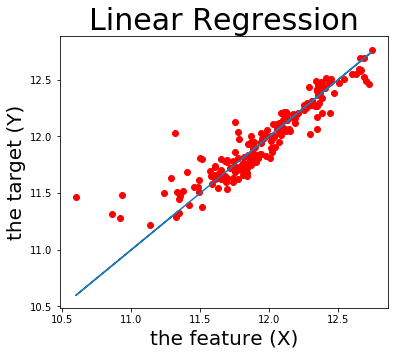

In [29]:
def get_predictplot(reg_model,y_test,y_preds): #Create plot to visualize the accuracy of the predicted values
    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.scatter(y_test, y_preds, color="red")
    plt.plot(y_test, y_test)
    plt.title(reg_model, fontsize=30)
    plt.xlabel("the feature (X)", fontsize=20)
    plt.ylabel("the target (Y)", fontsize=20)
    

get_predictplot('Linear Regression', y_test, y_preds_test_lrm)

In [201]:
lrm_score = cross_val_score(lrm,X_train, y_train, cv=4)
print("LRM Accuracy: %0.2f (+/- %0.2f)" % (lrm_score.mean(), lrm_score.std() * 2))

LRM Accuracy: 0.86 (+/- 0.04)


- Prediction values vs. test values tend toward the testing set line of fit, save for some outliers among the smaller values.
- LRM accuracy is also in the higher values with a lower variance.

### Lasso Regression Model

- With the Lasso regression model we address the effect of L1 regularization on our cost model.

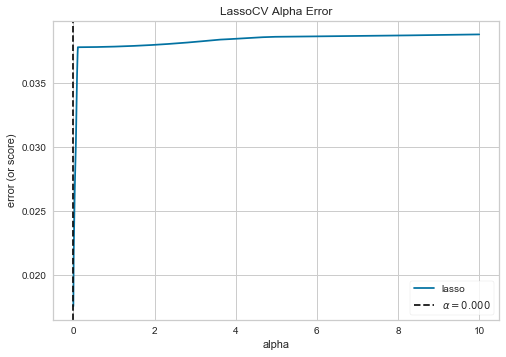

In [30]:
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection

# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 400)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)

visualizer.fit(X, Y)
g = visualizer.poof()

- From the alpha vs error plot we see the optimal hyperparameter tend towards zero when optimizing the under and over fit error.

In [31]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train_lasso = lasso_cv.predict(X_train)
y_preds_test_lasso = lasso_cv.predict(X_test)

get_metrics(lasso_cv,X_train,y_train,X_test,y_test,y_preds_test_lasso)

R-squared of the model in training set is: 0.8644140907443731
-----Test set statistics-----
R-squared of the model in test set is: 0.8485131053872643
Mean absolute error of the prediction is: 0.09495308294179348
Mean squared error of the prediction is: 0.02132192228034446
Root mean squared error of the prediction is: 0.146020280373462
Mean absolute percentage error of the prediction is: 0.808331557849038


-  From the R-value and error metrics of the Lasso model, we see alot of similarities from the OLS model.

- With the Lasso method, we take an interest in the MAE since L1 regularization is based on the the sum of the absolute weights.

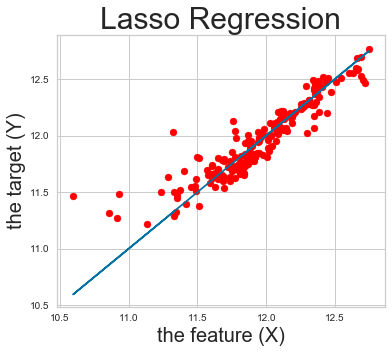

In [32]:
get_predictplot('Lasso Regression', y_test, y_preds_test_lasso) 
                                                    #Create plot to visualize the accuracy of the predicted values

In [203]:
lasso_score = cross_val_score(lasso_cv,X_train, y_train, cv=4) #Calculate the accuracy of the regression method
print("LASSO Accuracy: %0.2f (+/- %0.2f)" % (lasso_score.mean(), lasso_score.std() * 2))

LASSO Accuracy: 0.86 (+/- 0.04)


- Prediction values vs. test Lasso values also relate similar trends as the OLS model.

- Since the original model only encompasses a handful of features, it would be expected that a model with a greater quantity of predictors would benefit more from the Lasso Regression method than this simple model.

### Ridge Regression Model

- The Ridge regression model we address the effect of L2 regularization on our cost model.

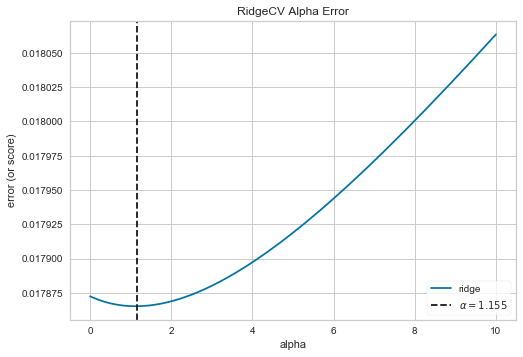

In [33]:
# Instantiate the linear model and visualizer
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)

visualizer.fit(X, Y)
g = visualizer.poof()

- Witht the visualizer plot we see the optimal alpha to minimize the over/under fit error tends towards a value just above one.

In [34]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train_ridge = ridge_cv.predict(X_train)
y_preds_test_ridge = ridge_cv.predict(X_test)

get_metrics(ridge_cv,X_train,y_train,X_test,y_test,y_preds_test_ridge)

R-squared of the model in training set is: 0.8643781073945468
-----Test set statistics-----
R-squared of the model in test set is: 0.8474810694816189
Mean absolute error of the prediction is: 0.0950506831382477
Mean squared error of the prediction is: 0.021467182300539265
Root mean squared error of the prediction is: 0.14651683282319225
Mean absolute percentage error of the prediction is: 0.8092016247545155


- As with the previous models, test and training R-values are seperated by less than 1.7 points and error metrics continue to stay lower in value. 
- In this instance, we look toward the MSE since L2 reglariztion is based on the sum of the squared weights.

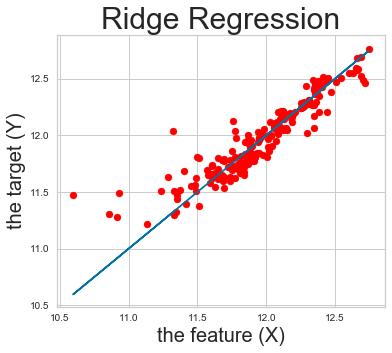

In [35]:
get_predictplot('Ridge Regression', y_test, y_preds_test_ridge)
                                                #Create plot to visualize the accuracy of the predicted values

In [205]:
ridge_score = cross_val_score(ridge_cv,X_train, y_train, cv=4) #Calculate the accuracy of the regression method
print("RIDGE Accuracy: %0.2f (+/- %0.2f)" % (ridge_score.mean(), ridge_score.std() * 2))

RIDGE Accuracy: 0.86 (+/- 0.04)


### Elastic Net Regression Model

- With the Elastic Net regression model we address the effect of L1 and L2 regularization on our cost model.

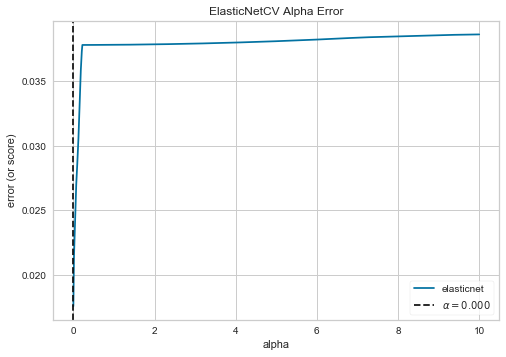

In [36]:
# Instantiate the linear model and visualizer
model = ElasticNetCV(alphas=alphas)
visualizer = AlphaSelection(model)

visualizer.fit(X, Y)
g = visualizer.poof()

- From the alpha vs error plot we see the optimal hyperparameter tend towards zero when optimizing the under and over fit error.

In [37]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train_enet = elasticnet_cv.predict(X_train)
y_preds_test_enet = elasticnet_cv.predict(X_test)

get_metrics(elasticnet_cv,X_train,y_train,X_test,y_test,y_preds_test_enet)

R-squared of the model in training set is: 0.8644140903181464
-----Test set statistics-----
R-squared of the model in test set is: 0.8485104610514382
Mean absolute error of the prediction is: 0.09495319233807453
Mean squared error of the prediction is: 0.021322294473088324
Root mean squared error of the prediction is: 0.14602155482355447
Mean absolute percentage error of the prediction is: 0.8083325717638347


- As expected, with reference to previous L1 and L2 regularization, the Elastic Net method continues to relate low error metrics. 

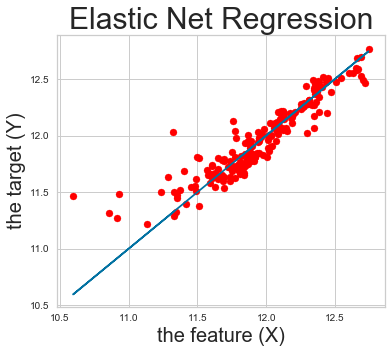

In [38]:
get_predictplot('Elastic Net Regression', y_test, y_preds_test_enet)
                                                    #Create plot to visualize the accuracy of the predicted values

In [206]:
enet_score = cross_val_score(elasticnet_cv,X_train, y_train, cv=4) #Calculate the accuracy of the regression method
print("ELASTICNET Accuracy: %0.2f (+/- %0.2f)" % (enet_score.mean(), enet_score.std() * 2))

ELASTICNET Accuracy: 0.86 (+/- 0.04)


In [40]:
metrics = pd.DataFrame() #Create dataframe to compare evaluation metrics 
metrics['Model Type'] = ('Linear', 'Lasso', 'Ridge', 'ElasticNet')
metrics['Train R'] = (lrm.score(X_train, y_train),lasso_cv.score(X_train, y_train),ridge_cv.score(X_train, y_train),elasticnet_cv.score(X_train, y_train))
metrics['Test R'] = (lrm.score(X_test, y_test), lasso_cv.score(X_test, y_test), ridge_cv.score(X_test, y_test), elasticnet_cv.score(X_test, y_test)) 
metrics['Mean absolute error'] = (mean_absolute_error(y_test, y_preds_test_lrm),mean_absolute_error(y_test, y_preds_test_lasso),mean_absolute_error(y_test, y_preds_test_ridge),mean_absolute_error(y_test, y_preds_test_enet))
metrics['Mean squared error'] = (mse(y_test, y_preds_test_lrm),mse(y_test, y_preds_test_lasso),mse(y_test, y_preds_test_ridge),mse(y_test, y_preds_test_enet))
metrics['Root mean squared error'] = (rmse(y_test, y_preds_test_lrm),rmse(y_test, y_preds_test_lasso),rmse(y_test, y_preds_test_ridge),rmse(y_test, y_preds_test_enet))
metrics['Mean absolute percentage error'] = (np.mean(np.abs((y_test - y_preds_test_lrm) / y_test)) * 100,np.mean(np.abs((y_test - y_preds_test_lasso) / y_test)) * 100,np.mean(np.abs((y_test - y_preds_test_ridge) / y_test)) * 100,np.mean(np.abs((y_test - y_preds_test_enet) / y_test)) * 100)
metrics['Train - Test'] = (metrics['Train R'] - metrics['Test R']).abs()
metrics['Score'] = (metrics['Train R'] + metrics['Test R'] + metrics['Mean absolute error'] 
                    + metrics['Mean squared error'] + metrics['Root mean squared error'] 
                    + metrics['Mean absolute percentage error'])
metrics

,Model Type,Train R,Test R,Mean absolute error,Mean squared error,Root mean squared error,Mean absolute percentage error,Train - Test,Score
0,Linear,0.864414,0.848513,0.094953,0.021322,0.146020,0.808332,0.015901,2.783554
1,Lasso,0.864414,0.848513,0.094953,0.021322,0.146020,0.808332,0.015901,2.783554
2,Ridge,0.864378,0.847481,0.095051,0.021467,0.146517,0.809202,0.016897,2.784095
3,ElasticNet,0.864414,0.848510,0.094953,0.021322,0.146022,0.808333,0.015904,2.783554


- We see very small variance between the different methods of regression, in this instance it would seems the OLS or Lasso prediction method is best overall given the smaller difference between the testing R scores and the training R scores.

## Including Economic Factors

- We look towards other datasets to incorporate other finacial predictors into our model.

In [107]:
#https://www.kaggle.com/junfeng142857/usa-unemployment-rate-from-1989-to-2017

unemployment_df = pd.read_csv('unemployment_rate.csv', sep=',', encoding='Latin-1') 
unemployment_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1989,5.4,5.2,5.0,5.2,5.2,5.3,5.2,5.2,5.3,5.3,5.4,5.4
1,1990,5.4,5.3,5.2,5.4,5.4,5.2,5.5,5.7,5.9,5.9,6.2,6.3
2,1991,6.4,6.6,6.8,6.7,6.9,6.9,6.8,6.9,6.9,7.0,7.0,7.3
3,1992,7.3,7.4,7.4,7.4,7.6,7.8,7.7,7.6,7.6,7.3,7.4,7.4
4,1993,7.3,7.1,7.0,7.1,7.1,7.0,6.9,6.8,6.7,6.8,6.6,6.5


In [108]:
unemployment_df['Unemployment Rate'] = unemployment_df.iloc[:,1:].mean(axis=1) #create column of averages

In [109]:
unemployment_df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Unemployment Rate
0,1989,5.4,5.2,5.0,5.2,5.2,5.3,5.2,5.2,5.3,5.3,5.4,5.4,5.258333
1,1990,5.4,5.3,5.2,5.4,5.4,5.2,5.5,5.7,5.9,5.9,6.2,6.3,5.616667
2,1991,6.4,6.6,6.8,6.7,6.9,6.9,6.8,6.9,6.9,7.0,7.0,7.3,6.850000
3,1992,7.3,7.4,7.4,7.4,7.6,7.8,7.7,7.6,7.6,7.3,7.4,7.4,7.491667
4,1993,7.3,7.1,7.0,7.1,7.1,7.0,6.9,6.8,6.7,6.8,6.6,6.5,6.908333


In [110]:
housing_newfactors_df =  housing_reg_df.copy()
housing_newfactors_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,exterqual_TA,bsmtqual_Fa,bsmtqual_Gd,bsmtqual_TA,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,totalsf
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,0,1,0,0,0,0,1,0,2566
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,0,1,0,0,0,0,1,0,2706
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,0,1,0,0,0,0,1,0,3343
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,0,0,0,0,0,0,1,0,3380
10,11,20,RL,70.0,11200,Pave,None,Reg,Lvl,AllPub,...,1,0,0,1,0,0,0,1,0,2080


- From a U.S. unemployment dataset, we include the yearly average unemployment rates into our housing dataframe.

- Unemployment data may be said to influence to purchasing potential of housing market customers.

In [111]:
housing_newfactors_df = pd.merge(housing_newfactors_df,unemployment_df,left_on=['yrsold'], right_on = ['Year'], how = 'left')
                                                        #combine unemployment data to housing data indexed by year


- From a U.S. Federal Reserve dataset we take yearly effective Federal interest rate data and Inflation rate data.

- Federal lending rates influence the cost of borrowing money for a home and inflation rates would influence the amount of money required to purchase a home. 

In [113]:
#https://www.kaggle.com/federalreserve/interest-rates

economic_df = pd.read_csv('index.csv', sep=',', encoding='Latin-1') # Read the four raw .csv file, store into data frames
economic_df.head()


,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [114]:
interest_df = economic_df.groupby('Year')[['Effective Federal Funds Rate','Inflation Rate']].agg(np.mean)
                            #create data frame of average federal interest rate and inflation rate, grouped by year
interest_df.head()

,Effective Federal Funds Rate,Inflation Rate
Year,,
1954,1.006667,NaN
1955,1.785000,NaN
1956,2.728333,NaN
1957,3.105000,NaN
1958,1.572500,2.283333


In [115]:
housing_newfactors_df = pd.merge(housing_newfactors_df,interest_df,left_on=['yrsold'], right_on = ['Year'], how = 'left')
                                            #combine interest and inflation data to housing data indexed by year
housing_newfactors_df.head()


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Unemployment Rate,Effective Federal Funds Rate,Inflation Rate
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,5.6,5.8,6.1,6.1,6.5,6.8,7.3,5.800000,1.927500,2.308333
1,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,5.6,5.8,6.1,6.1,6.5,6.8,7.3,5.800000,1.927500,2.308333
2,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,5.6,5.8,6.1,6.1,6.5,6.8,7.3,5.800000,1.927500,2.308333
3,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,4.6,4.7,4.6,4.7,4.7,4.7,5.0,4.616667,5.019167,2.325000
4,11,20,RL,70.0,11200,Pave,None,Reg,Lvl,AllPub,...,5.6,5.8,6.1,6.1,6.5,6.8,7.3,5.800000,1.927500,2.308333


- Taking the new data, OLS and Lasso regression is used to assess the effective predicting power of the new financial features.

In [133]:
# Y is the target variable

Y_nf = list(np.log1p(housing_newfactors_df['saleprice']))
# X is the feature set
X_nf = housing_newfactors_df[['overallqual', 'garagecars', 'totalbsmtsf', 'centralair_Y',
                     'bldgtype_Twnhs','bldgtype_TwnhsE','exterqual_TA','bsmtqual_Fa','bsmtqual_Gd',
                     'bsmtqual_TA','salecondition_Normal','salecondition_Partial', 'totalsf', 'Unemployment Rate',
                     'Inflation Rate','Effective Federal Funds Rate']]

In [156]:
X_nf = sm.add_constant(X_nf)

results = sm.OLS(Y_nf, X_nf).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     373.0
Date:                Thu, 27 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:36:54   Log-Likelihood:                 593.83
No. Observations:                 969   AIC:                            -1154.
Df Residuals:                     952   BIC:                            -1071.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           10.6860      0.123     87.045      0.000      10.445      10.927
overallqual                      0.0741      0.006     12.599      0.000       0.063       0.086
garagecars                       0.0700      0.009      8.157      0.000       0.053       0.087
totalbsmtsf                  -8.896e-05   2.02e-05     -4.410      0.000      -0.000   -4.94e-05
centralair_Y                     0.2277      0.021     10.609      0.000       0.186       0.270
bldgtype_Twnhs                  -0.1239      0.022     -5.641      0.000      -0.167      -0.081
bldgtype_TwnhsE                 -0.0575      0.016     -3.596      0.000      -0.089      -0.026
exterqual_TA                    -0.0321      0.013     -2.430      0.015      -0.058      -0.006
bsmtqual_Fa                     -0.1823      0.035     -5.229      0.000      -0.251      -0.114
bsmtqual_Gd                     -0.0412      0.017     -2.429      0.015      -0.074      -0.008
bsmtqual_TA                     -0.1227      0.019     -6.297      0.000      -0.161      -0.084
salecondition_Normal             0.0907      0.016      5.751      0.000       0.060       0.122
salecondition_Partial            0.1058      0.023      4.679      0.000       0.061       0.150
totalsf                          0.0003    1.4e-05     20.519      0.000       0.000       0.000
Unemployment Rate               -0.0051      0.009     -0.552      0.581      -0.023       0.013
Inflation Rate                  -0.0185      0.023     -0.811      0.418      -0.063       0.026
Effective Federal Funds Rate    -0.0010      0.006     -0.163      0.871      -0.013       0.011
==============================================================================
Omnibus:                      251.595   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1229.912
Skew:                          -1.110   Prob(JB):                    8.47e-268
Kurtosis:                       8.053   Cond. No.                     7.95e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.95e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Comparing this new summary to the original OLS, we see here that our F-statistic equal to 373 is statistically significant with a p-value equal to zero, however relates a smaller ratio based on the reduced model than the original OLS which had a F-statistic of 460. 
- We also notice our new features relate a probability value above the usual .05 threshold. While this may be expected as the new features come from an outside source and may represent an entirely different method of value collection and calculation.

### Linear and Lasso regression methods are used to see if the new features have any effect on model accuracy.

In [209]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_nf, Y_nf, test_size = 0.2, random_state = 465)
                                                                                    #split data, hold 20% for testing

In [210]:
lrm = LinearRegression()

lrm.fit(X_train2, y_train2)

# We are making predictions here
y_preds_train_lrm_nf = lrm.predict(X_train2)
y_preds_test_lrm_nf = lrm.predict(X_test2)

get_metrics(lrm,X_train2,y_train2,X_test2,y_test2,y_preds_test_lrm_nf)

R-squared of the model in training set is: 0.8648711548659963
-----Test set statistics-----
R-squared of the model in test set is: 0.8456668680300846
Mean absolute error of the prediction is: 0.09603622035784942
Mean squared error of the prediction is: 0.021722532853795978
Root mean squared error of the prediction is: 0.1473856602719409
Mean absolute percentage error of the prediction is: 0.8176253105485802


- A linear regression model with the new features still included relate R scores with a 1.9 point difference and error metrics that are lower in value.

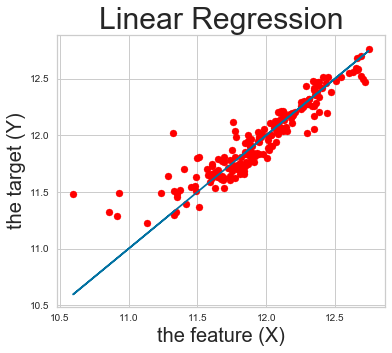

In [211]:
get_predictplot('Linear Regression', y_test2, y_preds_test_lrm_nf)

In [212]:
lrm_nf_score = cross_val_score(lrm,X_train2, y_train2, cv=4) #Calculate the accuracy of the regression method
print("LRM Accuracy: %0.2f (+/- %0.2f)" % (lrm_nf_score.mean(),lrm_nf_score.std() * 2))

LRM Accuracy: 0.86 (+/- 0.04)


In [213]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train2, y_train2)

# We are making predictions here
y_preds_train_lasso = lasso_cv.predict(X_train2)
y_preds_test_lasso = lasso_cv.predict(X_test2)

get_metrics(lasso_cv,X_train2,y_train2,X_test2,y_test2,y_preds_test_lasso)

R-squared of the model in training set is: 0.8648711548659963
-----Test set statistics-----
R-squared of the model in test set is: 0.8456668676518432
Mean absolute error of the prediction is: 0.09603622026458296
Mean squared error of the prediction is: 0.021722532907033805
Root mean squared error of the prediction is: 0.1473856604525481
Mean absolute percentage error of the prediction is: 0.8176253097648297


- A Lasso regression on the new feature model coninues the previous Linear regression trend in R scores and error metrics.

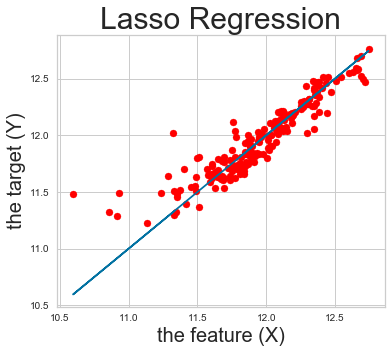

In [214]:
get_predictplot('Lasso Regression', y_test2, y_preds_test_lasso)

In [215]:
lasso_nf_score = cross_val_score(lasso_cv,X_train2, y_train2, cv=4) #Calculate the accuracy of the regression method
print("LASSO Accuracy: %0.2f (+/- %0.2f)" % (lasso_nf_score.mean(),lasso_nf_score.std() * 2))

LASSO Accuracy: 0.86 (+/- 0.04)


- Even with the financial features included in the model, prediction accuracy remains consistent. 

## Conclusion

In summary the OLS or Lasso regression methods were chosen above the Ridge and ElasticNet methods, although very similar evaluation metrics shared amongst the types, the OLS and Lasso methos were shown to have the smallest differential between the training and testing R scores. This difference indicates that the predicted values from these forms of model optimization were closest in nature to the target values of the testing data set. 

The model investigation continued and more features were brought in from other data sources, unemployment data, inflation, and federal interest rate data was added to assess the affects of adding predictors to a model's accuracy. Unfortunately the new features were not found to be statistically significant as the probability values of the predictor coefficients fell short of the usual .05 probability threshold. However, carrying through with OLS and Lasso regression performed on the linear model including the new features the model was shown to maintain its predictive capabilities. The R scores between the testing and training datasets also maintain their differential, similar in value to the models that did not contain the new features. As we know loading predictors onto our model may result in high R score while in the training steps, we may expect the testing set R score to be quite different in value. If substantial, this difference would indicate we had overfit the model with to many features and lost the optimal level of generalization that would make our model useful.

If we were to continue to bring in features not included in the original houising dataset, we may expect the Lasso regression method to return more favorable result over OLS. Such that Lasso regression prevents overfitting, given the nature of the methods L1 regularization and this method's ability to tend smaller coefficients to equal zero, thusly creating an easily understood, computationally simple model.